In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

## Implementation of context parroting

In [2]:
def delay_embedding(data, D=30, tau=1):
    """
    Create a delay embedding of a time series

    Args:
        data: 1D array representing the context trajectory
        D: embedding dimension
        tau: delay used for the embedding

    Returns:
        embedded_data: Delay embedded data

    Usage:
        arr = np.array([1,2,3,4,5,6,7,8,9])
        delay_embedding(arr,5,1)
    """
    N = len(data)
    indices = np.arange(D) * tau + np.arange(N - (D - 1) * tau)[:, None]
    embedded_data = data[indices]

    return embedded_data

def embedding_distance(data, D=30, tau=1):
    """
    Calculate the L2 distance in a delay-embedded space

    Args:
        data (array-like): 1D array representing the context trajectory
        D (int): Motif length, embedding dimension (default 30).
        tau (int): delay used for the embedding (default 1).

    Returns:
        min_l2_distance: Minimum L2 distance in the embedding space
    """

    # Create delay embeddings
    embedded_data = delay_embedding(data, D=D, tau=tau)

    # Compute distance of other points to the last point in the embedding space using L2 norm
    last_point = embedded_data[-1]
    l2_distance = cdist(embedded_data[:-D * tau], last_point[None, :])

    return l2_distance

In [3]:
def context_parroting_forecast(data, D=30, tau=1, forecast_total_length=300):
    """
    Simple forecasting model based on context parroting.

    Args:
        data (array-like): The input 1D array representing the context trajectory.
        D (int): Motif length, embedding dimension (default 30).
        tau (int): delay used for the embedding (default 1).
        forecast_total_length (int): Desired length of the forecasted output (default 300).

    Returns:
        best_index (int): Index of the best-matching context point.
        min_embedding_distance (float): Minimum L2 distance in the embedding space.
        forecast (array-like): Forecasted sequence of the specified length.
    """

    # Calculate embedding distances
    embedding_distances = embedding_distance(data, D=D, tau=tau)
    min_embedding_distance = np.min(embedding_distances)

    # Find the index with the minimum embedding distance
    min_index = np.argmin(embedding_distances)
    best_index = min_index + (D-1)*tau + 1

    # Extract the motif starting from the best-matching index
    motif = data[best_index:-1]
    motif_length = len(motif)

    # Repeat the motif to create a forecast of the desired length
    num_repeats = forecast_total_length // motif_length + 1
    forecast = np.tile(motif, num_repeats)[:forecast_total_length]

    return best_index, min_embedding_distance, forecast

## Simple demo applying context parroting to the Lorenz system

In [4]:
context_length = 512
forecast_length = 300
dim = 0
D = 30

# Load the Lorenz system data
equation_name = 'Lorenz'
traj = np.load(f"{equation_name}.npy")

traj_context = traj[:context_length, :]
#traj_true = traj[context_length:context_length+forecast_length, :]

best_index, min_l2_distance, traj_pred = context_parroting_forecast(traj_context[:,dim], D=D)

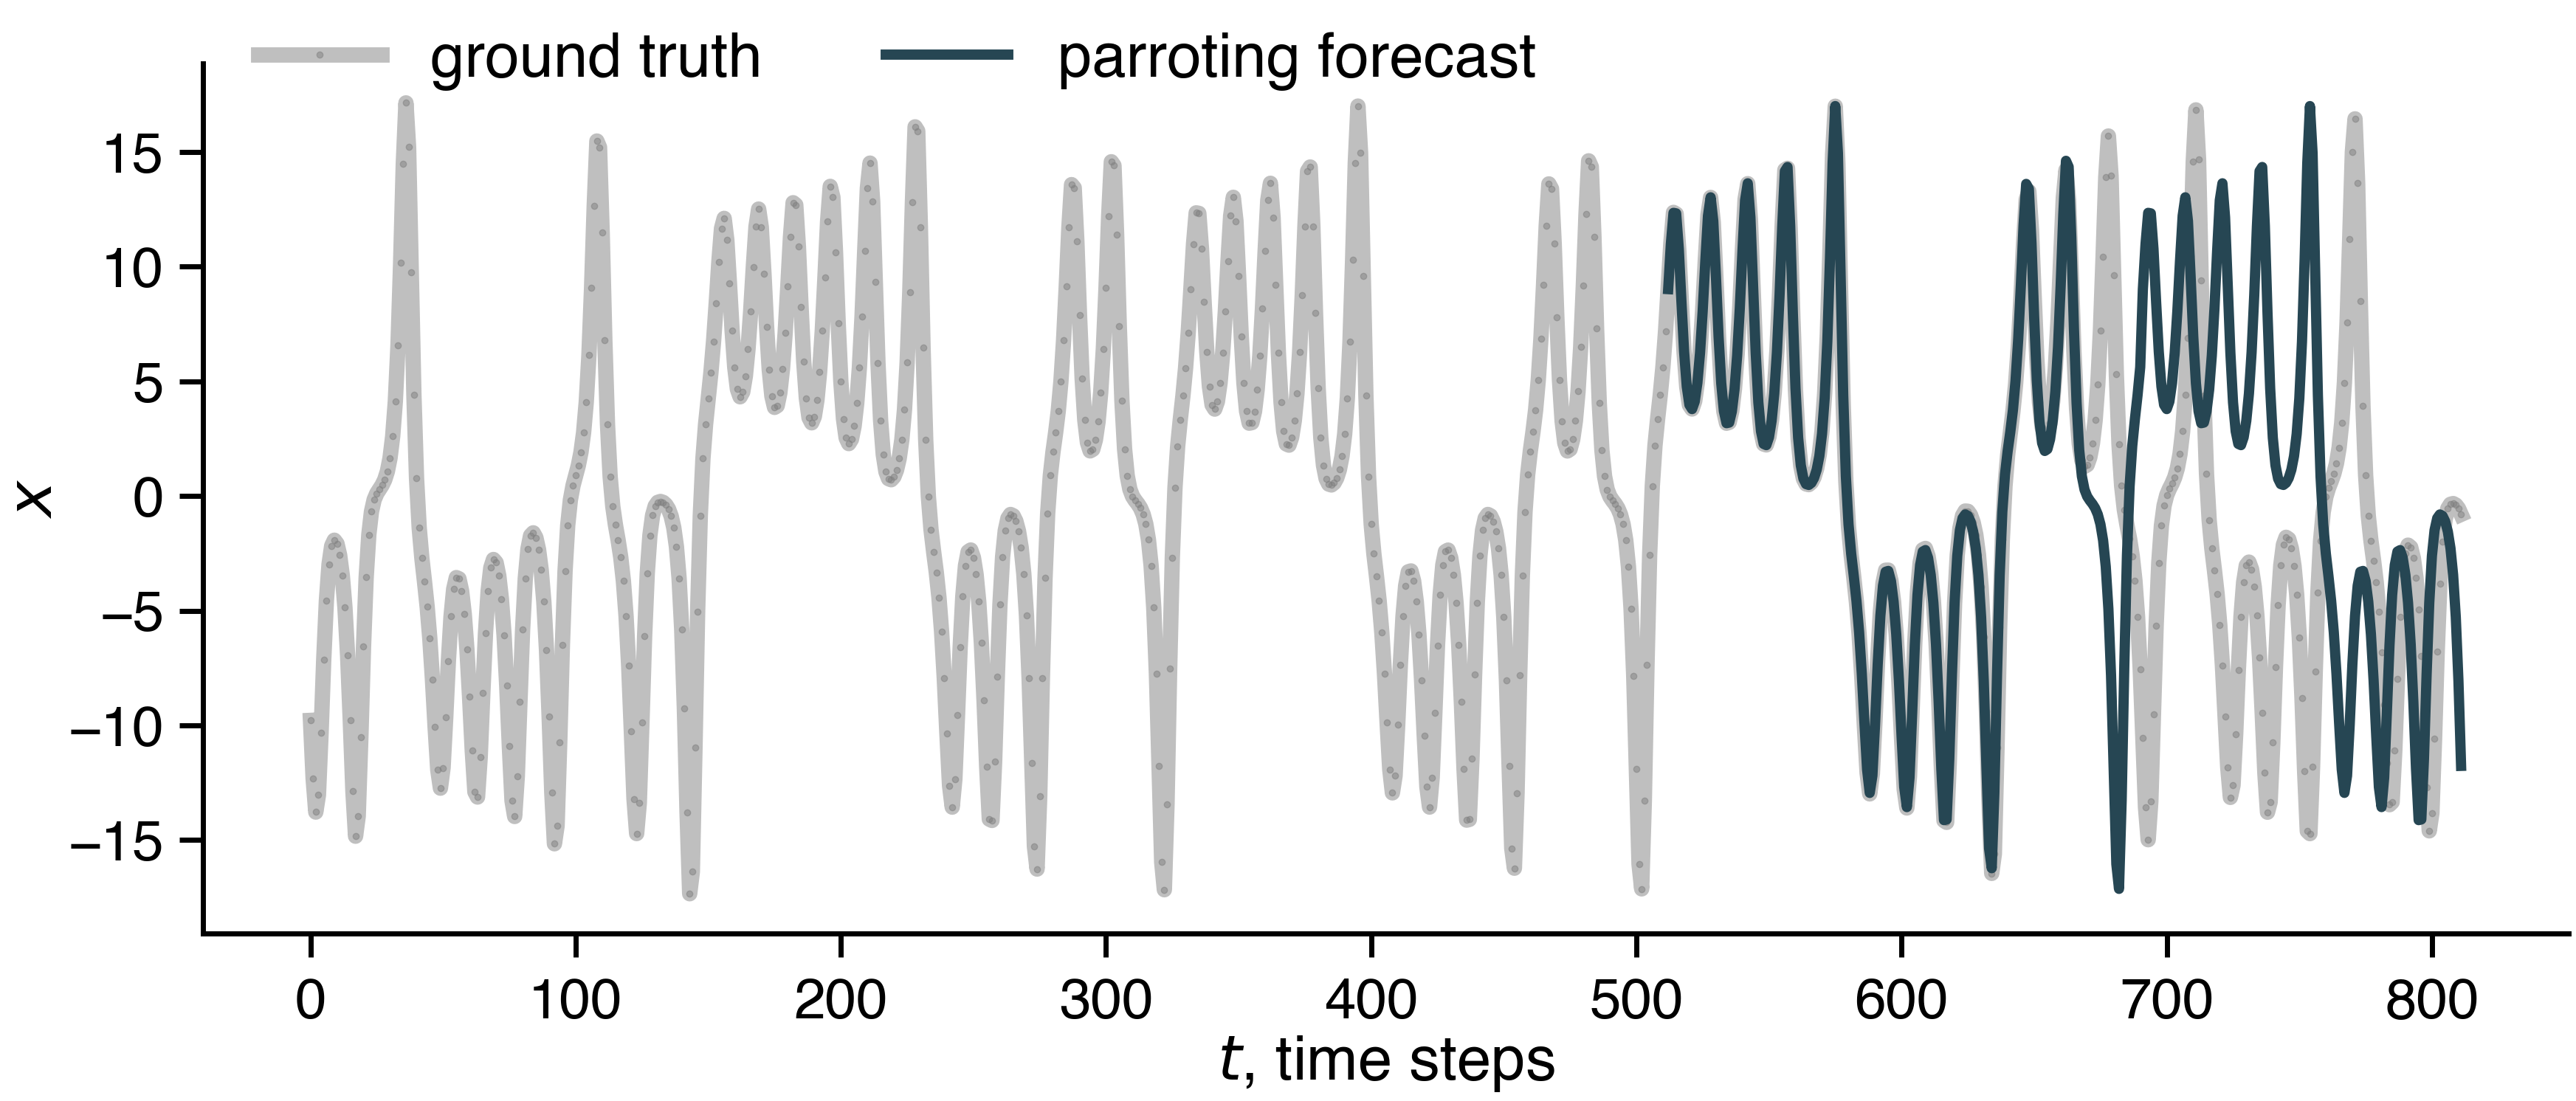

In [5]:
plt.rcParams["font.family"] = "Helvetica"
colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]

fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(35,15)
plt.xticks(fontsize = 55)
plt.yticks(fontsize = 55)
plt.xlabel(r'$t$, time steps',fontsize = 60)
plt.ylabel(r'$x$',fontsize = 60)

plt.plot(traj[:context_length+forecast_length, dim], lw=15, ls='-', marker='o', color='gray', alpha=.5, label="ground truth")
plt.plot(range(context_length,context_length+forecast_length), traj_pred, lw=10, ls='-', color=colors[0], alpha=1, label="parroting forecast")

plt.legend(loc='upper left', frameon=False, prop={'size':60}, ncol=3, bbox_to_anchor=(0, 1.1))
plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

#plt.xlim([context_length,context_length+forecast_length])

fig.set_tight_layout(True)
plt.show()